In [ ]:
import numpy as np
import torch
from torch import nn
import seaborn as sns
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

# Train Model

### Dataloader

In [ ]:
class SmokingDataset(Dataset):
    def __init__(self, dir):
        self.dir = dir
    
    def __len__(self):
        return len(os.listdir(self.dir))
    
    def __getitem__(self, key):
        if isinstance(key, slice):
            stop, start, step = key.indices(len(self))

            length = len(range(stop, start, step))
            X = torch.zeros([length, 300])
            y = torch.zeros([length, 1])

            for j,i in enumerate(range(stop, start, step)):
                xi, yi = self[i]
                X[j] = xi
                y[j] = yi

            return (X, y)

        elif isinstance(key, int):
            X, y = torch.load(os.path.join(self.dir, f'{key}.pt'))
            return (X.flatten(), y)

In [ ]:
train_dataset = SmokingDataset('pipeline/4_all/train/')
test_dataset = SmokingDataset('pipeline/4_all/test/')

train_length = len(train_dataset)
test_length = len(test_dataset)

In [ ]:
# Get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

In [ ]:
# Define Model
n_hl = 10

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(300, n_hl),
            nn.ReLU(),
            nn.Linear(n_hl, 1)
        )
    
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits  

model = MLP().to(device)
    
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [34]:
# Define training parameters and preapre dataloaders from saved datasets

epochs = 10
batch_size = 64

losses = []
test_losses = []

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=907)    # batches for memory

n_train_batches = len(train_dataloader)
n_test_batches = len(test_dataloader)

In [35]:
# Train
for epoch in range(epochs):

    print(f'Epoch {epoch} - Training')
    model.train()
    for X_train, y_train in tqdm(train_dataloader):

        X_train = X_train.to(device)
        y_train = y_train.to(device)

        # Forward Pass
        logits = model(X_train)
        loss = criterion(logits, y_train)

        # Backward Pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    
    print(f'loss: {sum(losses[-n_train_batches:])/n_train_batches}')


    ## Test
    print(f'Epoch {epoch} - Testing')
    model.eval()

    preds = []
    n_correct = 0

    for X_test, y_test in tqdm(test_dataloader):
        X_test = X_test.to(device)
        y_test = y_test.to(device)

        logits = model(X_test)
        pred = torch.round(nn.Sigmoid()(logits))

        n_correct += sum(y_test == pred)
        preds += pred.flatten().tolist()
        loss = criterion(logits, y_test)
        test_losses.append(loss.item())


    accuracy = (n_correct / test_length).item()
    print(f'Test Accuracy: {100*accuracy:.4}%')
    print(f'Test Loss: {sum(test_losses[-n_test_batches:])/n_test_batches}')

    os.system('mkdir model')
    torch.save(model.state_dict(), f'model/model-epoch{epoch}.pt')

Epoch 0 - Training


100%|██████████| 13393/13393 [02:42<00:00, 82.59it/s]


loss: 0.09346771406026899
Epoch 0 - Testing


100%|██████████| 405/405 [01:02<00:00,  6.46it/s]
mkdir: cannot create directory ‘model’: File exists


Test Accuracy: 96.7%
Test Loss: 0.09268156560482803
Epoch 1 - Training


100%|██████████| 13393/13393 [02:40<00:00, 83.52it/s]


loss: 0.09177062260746004
Epoch 1 - Testing


100%|██████████| 405/405 [01:02<00:00,  6.53it/s]
mkdir: cannot create directory ‘model’: File exists


Test Accuracy: 96.73%
Test Loss: 0.0917143736080623
Epoch 2 - Training


100%|██████████| 13393/13393 [02:49<00:00, 78.94it/s]


loss: 0.09085905825832793
Epoch 2 - Testing


100%|██████████| 405/405 [01:11<00:00,  5.63it/s]
mkdir: cannot create directory ‘model’: File exists


Test Accuracy: 96.74%
Test Loss: 0.09085718263630514
Epoch 3 - Training


100%|██████████| 13393/13393 [02:59<00:00, 74.68it/s]


loss: 0.09024954142908027
Epoch 3 - Testing


100%|██████████| 405/405 [01:06<00:00,  6.07it/s]
mkdir: cannot create directory ‘model’: File exists


Test Accuracy: 96.77%
Test Loss: 0.09030410133210229
Epoch 4 - Training


100%|██████████| 13393/13393 [02:49<00:00, 78.98it/s]


loss: 0.08967265875335612
Epoch 4 - Testing


100%|██████████| 405/405 [01:03<00:00,  6.36it/s]
mkdir: cannot create directory ‘model’: File exists


Test Accuracy: 96.8%
Test Loss: 0.08991668711841842
Epoch 5 - Training


100%|██████████| 13393/13393 [02:52<00:00, 77.77it/s]


loss: 0.0890857188902493
Epoch 5 - Testing


100%|██████████| 405/405 [01:05<00:00,  6.18it/s]
mkdir: cannot create directory ‘model’: File exists


Test Accuracy: 96.82%
Test Loss: 0.08948368182704773
Epoch 6 - Training


100%|██████████| 13393/13393 [02:50<00:00, 78.39it/s]


loss: 0.08843858466838088
Epoch 6 - Testing


100%|██████████| 405/405 [01:07<00:00,  6.02it/s]
mkdir: cannot create directory ‘model’: File exists


Test Accuracy: 96.84%
Test Loss: 0.0888530862092236
Epoch 7 - Training


100%|██████████| 13393/13393 [02:48<00:00, 79.58it/s]


loss: 0.08789040586293784
Epoch 7 - Testing


100%|██████████| 405/405 [01:05<00:00,  6.21it/s]
mkdir: cannot create directory ‘model’: File exists


Test Accuracy: 96.83%
Test Loss: 0.0889057169449918
Epoch 8 - Training


100%|██████████| 13393/13393 [02:49<00:00, 79.07it/s]


loss: 0.08746380965639637
Epoch 8 - Testing


100%|██████████| 405/405 [01:09<00:00,  5.81it/s]
mkdir: cannot create directory ‘model’: File exists


Test Accuracy: 96.85%
Test Loss: 0.08886820214030183
Epoch 9 - Training


100%|██████████| 13393/13393 [02:41<00:00, 82.78it/s]


loss: 0.08716274748259319
Epoch 9 - Testing


100%|██████████| 405/405 [01:06<00:00,  6.05it/s]

Test Accuracy: 96.85%
Test Loss: 0.08862834542437836



mkdir: cannot create directory ‘model’: File exists


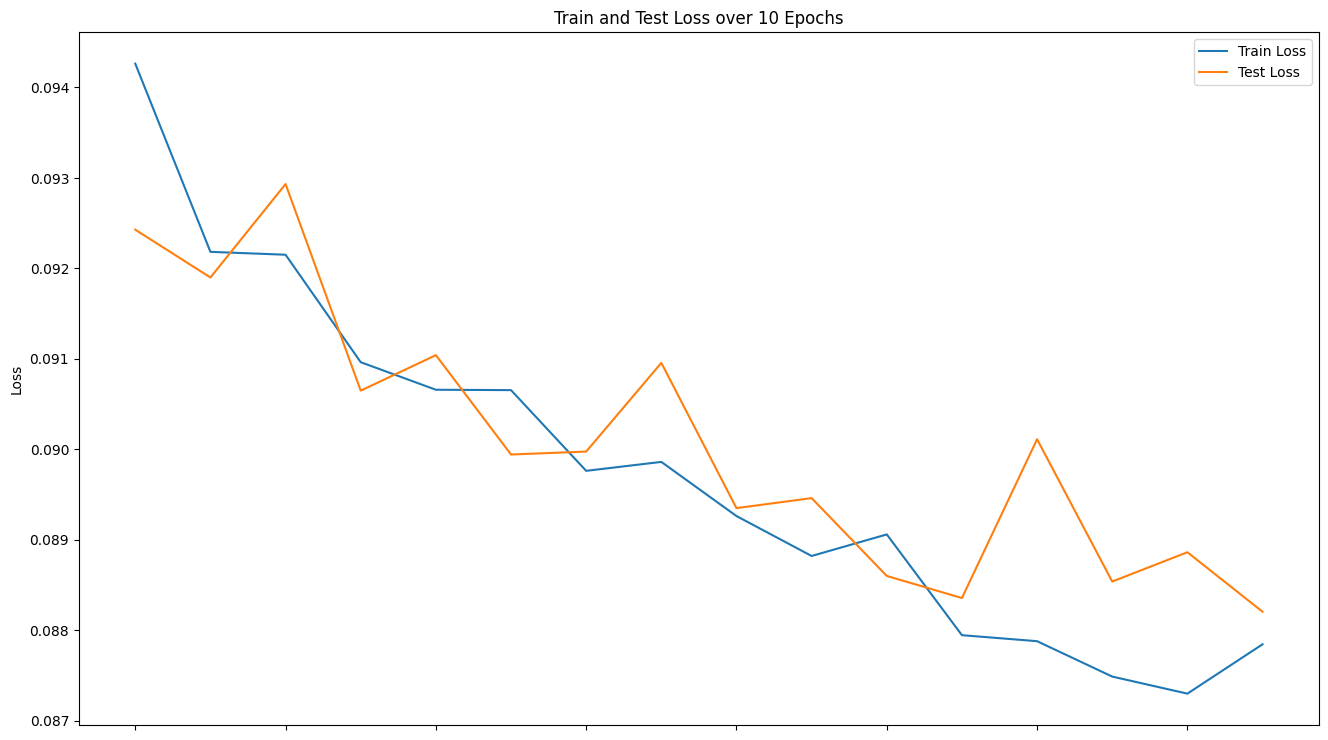

In [57]:
# Plot loss curve at specified resolution
res = 8000

factor = round(len(losses) / len(test_losses))
test_losses_toplot = np.pad(np.pad(np.array(test_losses).reshape(-1, 1), ((0,0), (0,factor-1)), mode='edge').flatten(), (0, len(losses) - len(test_losses)*factor), mode='edge')

fig, ax = plt.subplots(1)
ax.plot(torch.tensor(losses)[:len(losses)-len(losses)%res].view(-1,res).mean(1), label='Train Loss')
ax.plot(torch.tensor(test_losses_toplot)[:len(test_losses_toplot)-len(test_losses_toplot)%res].view(-1,res).mean(1), label='Test Loss')
ax.set_ylabel("Loss")
ax.set_xticklabels([])
ax.legend()
ax.set_title('Train and Test Loss over 10 Epochs')
fig.set_size_inches(16, 9)
plt.savefig('loss.jpg', dpi=400)

In [53]:
# Test on test dataset
model.eval()

preds = []
n_correct = 0
loss = 0
i =0
for X_test, y_test in tqdm(test_dataloader):
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    logits = model(X_test)
    pred = torch.round(nn.Sigmoid()(logits))

    n_correct += sum(y_test == pred)
    preds += pred.flatten().tolist()
    loss += criterion(logits, y_test).item()
    i+=1

y_pred = np.array(preds).reshape(-1,1)
accuracy = (n_correct / test_length).item()
loss = loss / len(test_dataloader)
print(f'Accuracy: {100*accuracy:.4}%')
print(f'Loss: {loss:.5}')



100%|██████████| 405/405 [01:17<00:00,  5.22it/s]


Accuracy: 96.85%
Loss: 0.088628


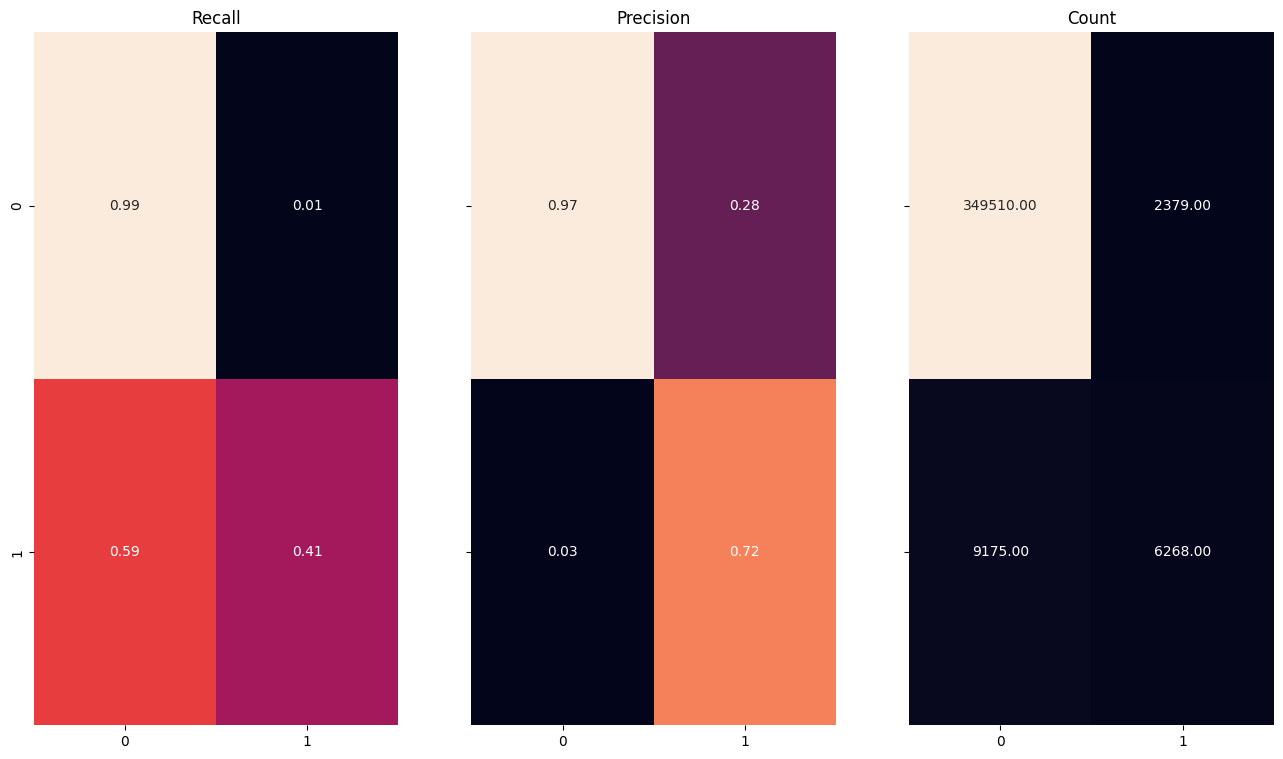

In [55]:
# Confusion Matrix

y_true = test_dataset[:][1]

fig,axes = plt.subplots(1,3,sharey=True,figsize=(10,5))
sns.heatmap(confusion_matrix(y_true=y_true,y_pred=y_pred,normalize='true'),annot=True,ax=axes[0],cbar=False,fmt='.2f')
sns.heatmap(confusion_matrix(y_true=y_true,y_pred=y_pred,normalize='pred'),annot=True,ax=axes[1],cbar=False,fmt='.2f')
sns.heatmap(confusion_matrix(y_true=y_true,y_pred=y_pred),annot=True,ax=axes[2],cbar=False,fmt='.2f')
axes[0].set_title('Recall')
axes[1].set_title('Precision')
axes[2].set_title('Count')
fig.set_size_inches(16, 9)
plt.savefig(f'cm.jpg',dpi=400,bbox_inches='tight')

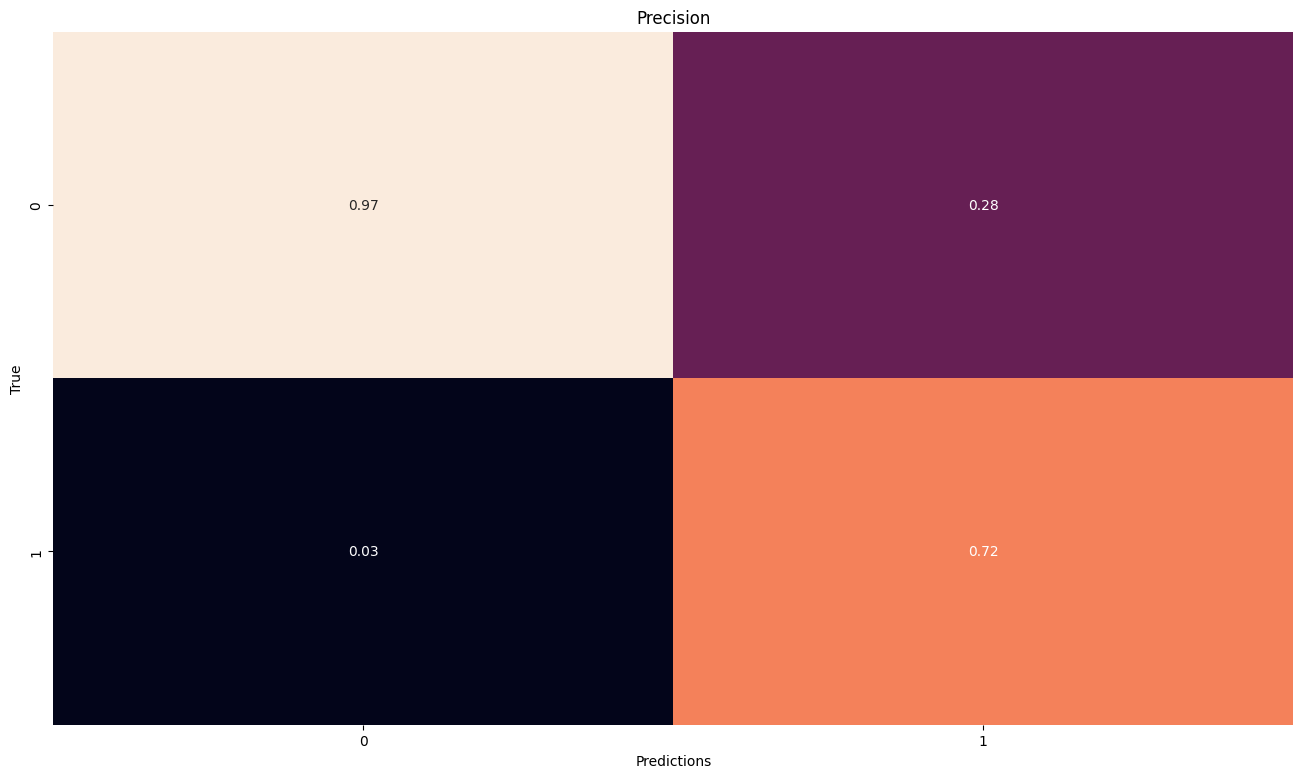

In [62]:
# Confusion Matrix (precision)

y_true = test_dataset[:][1]

fig,axes = plt.subplots(1,figsize=(16,9))
sns.heatmap(confusion_matrix(y_true=y_true,y_pred=y_pred,normalize='pred'),annot=True,ax=axes,cbar=False,fmt='.2f')
axes.set_title('Precision')
axes.set_xlabel("Predictions")
axes.set_ylabel("True")
plt.savefig(f'cm_pres.jpg',dpi=400,bbox_inches='tight')

In [ ]:
# Save model

os.system('mkdir model')
torch.save(model.state_dict(), 'model/model.pt')

In [67]:
import dill
dill.dump_session('archive/1_train_on_continous_env.db')